In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

#anzahl_kerne = os.cpu_count()
#print(f"Anzahl der CPU-Kerne: {anzahl_kerne}")

# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.analize.nervousness_comparator as nerv_comparator
import src.utils.analize.plotter_proof as proof
import src.utils.analize.calc as calc


# Extern
import pandas as pd
pd.set_option('display.max_rows', 26)


In [2]:
data_path = get_path("data", "experiments")

def get_file_path(prefix: str = "", text: str = "schedule"):
    return data_path / f"{prefix}_{text}.csv"


def get_jobs_with_lateness_metrics(df_plan_in):
    """
    Gibt für jeden Job die letzte Operation zurück und ergänzt Lateness, Tardiness und Earliness.

    Parameter:
    df_plan_in (pd.DataFrame): DataFrame mit Spalten 'Job', 'Operation', 'End', 'Deadline'

    Rückgabe:
    pd.DataFrame: Gefilterter und erweiterter DataFrame mit Lateness-Metriken
    """
    # 1. Letzte Operation je Job selektieren
    df = df_plan_in.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last').copy()

    # 2. Lateness-Metriken berechnen
    df["Lateness"] = df["End"] - df["Deadline"]
    df["Tardiness"] = df["Lateness"].clip(lower=0)
    df["Earliness"] = (-df["Lateness"]).clip(lower=0)

    return df


def append_plans_and_last_ops(df_plan_list: list, df_last_ops_list: list,
                              schedule_type: str, last_planning_start: int, prefix: str = "CP"):
    for day_numb in range(2, last_planning_start + 1):
        file = get_file_path(prefix=prefix, text=f"{day_numb:02d}_schedule_{schedule_type}")
        df_plan_temp = pd.read_csv(file)
        df_plan_temp = df_plan_temp.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
        df_plan_list.append(df_plan_temp)

        df_last_ops = get_jobs_with_lateness_metrics(df_plan_temp)
        df_last_ops_list.append(df_last_ops)

## Tag 1 (init)

In [3]:
day_numb = 1
file = get_file_path(prefix="CP", text=f"{day_numb:02d}_schedule")

df_plan_init =  pd.read_csv(file)
df_plan_init = get_jobs_with_lateness_metrics(df_plan_init)
df_plan_init

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
156,J25-0000,8,79,1440,3660,9,M08,3586,74,3660,0,0,0
89,J25-0001,6,129,1440,2338,9,M04,2283,55,2338,0,0,0
157,J25-0002,0,198,1440,3744,9,M09,3723,21,3744,0,0,0
152,J25-0003,2,243,1440,3379,9,M04,3346,33,3379,0,0,0
159,J25-0004,3,287,1440,4856,9,M05,4813,43,4856,0,0,0
147,J25-0005,1,498,1440,3106,9,M08,3076,30,3106,0,0,0
154,J25-0006,9,790,1440,3539,9,M07,3494,45,3539,0,0,0
143,J25-0007,5,925,1440,2929,9,M07,2904,25,2929,0,0,0
153,J25-0008,4,988,1440,3541,9,M06,3488,53,3541,0,0,0
155,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578,0,0,0


In [4]:
df_last_ops_init = df_plan_init.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
df_last_ops_init.head()

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
156,J25-0000,8,79,1440,3660,9,M08,3586,74,3660,0,0,0
89,J25-0001,6,129,1440,2338,9,M04,2283,55,2338,0,0,0
157,J25-0002,0,198,1440,3744,9,M09,3723,21,3744,0,0,0
152,J25-0003,2,243,1440,3379,9,M04,3346,33,3379,0,0,0
159,J25-0004,3,287,1440,4856,9,M05,4813,43,4856,0,0,0


## Listen der Schedules

### a) einfache Neuplanung mit der Berücksichtigung bereits aktiver Arbeitsgänge ("Simple")

In [5]:
# init simple
df_plan_simple_list = []
df_plan_simple_last_ops_list = []

df_plan_simple_list.append(df_plan_init)
df_plan_simple_last_ops_list.append(df_last_ops_init)

In [6]:
append_plans_and_last_ops(
    df_plan_list=df_plan_simple_list, df_last_ops_list=df_plan_simple_last_ops_list,
    schedule_type="simple", last_planning_start = 5
)

In [7]:
df_plan_simple_last_ops_list[-1]

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
4,J25-0038,3,2972,4320,7669,9,M05,7741,43,7784,115,115,0
10,J25-0042,8,3195,4320,7213,9,M08,7480,74,7554,341,341,0
14,J25-0048,7,3494,4320,7551,9,M03,7516,79,7595,44,44,0
22,J25-0064,2,4334,5760,7976,9,M04,8205,33,8238,262,262,0
30,J25-0065,4,4375,5760,7640,9,M06,7901,53,7954,314,314,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,J25-0099,3,6617,7200,8140,9,M05,8368,43,8411,271,271,0
287,J25-0100,6,6662,7200,9014,9,M04,8972,55,9027,13,13,0
297,J25-0101,0,6881,7200,8928,9,M09,8906,21,8927,-1,0,1
307,J25-0102,5,6891,7200,9344,9,M07,9319,25,9344,0,0,0


### b)  Neuplanung mit zusätzlicher Minimierung der Planabweichung ("Devpen")
- Abweichung der Starts der zuvor geplanten Arbeitsgänge (Operations) wurde in der Minimierungsfunktion berücksichtigung

In [8]:
# init devpen
df_plan_devpen_list = []
df_plan_devpen_last_ops_list = []

df_plan_devpen_list.append(df_plan_init)
df_plan_devpen_last_ops_list.append(df_last_ops_init)

In [9]:
append_plans_and_last_ops(
    df_plan_list=df_plan_devpen_list, df_last_ops_list=df_plan_devpen_last_ops_list,
    schedule_type="devpen", last_planning_start = 5
)

## Vergleich der Scheduling-Typen

In [10]:
simple_tardi_ratio, simple_earli_ratio, simple_ideal_ratio = calc.compute_tardiness_earliness_ideal_ratios(df_plan_simple_last_ops_list)
devpen_tardi_ratio, devpen_earli_ratio, devpen_ideal_ratio = calc.compute_tardiness_earliness_ideal_ratios(df_plan_devpen_last_ops_list)

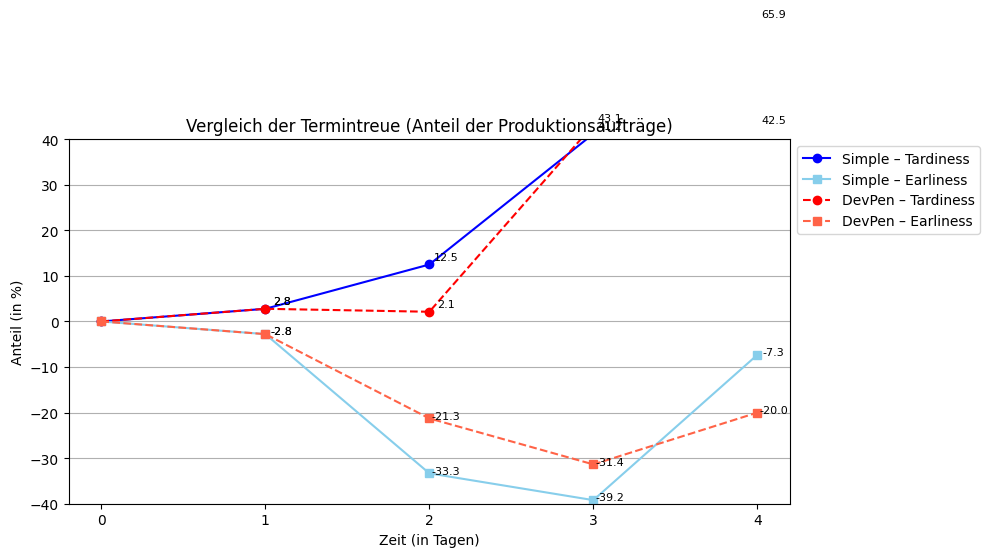

In [11]:
proof.plot_tardiness_earliness_two_methods(
    tardiness_A=simple_tardi_ratio,
    earliness_A=simple_earli_ratio,
    tardiness_B=devpen_tardi_ratio,
    earliness_B=devpen_earli_ratio,
    labels=("Simple", "DevPen"),
    ylabel="Anteil (in %)",
    subtitle = "(Anteil der Produktionsaufträge)",
    y_lim_min=-40,
    y_lim_max=40,
    as_percentage=True
)


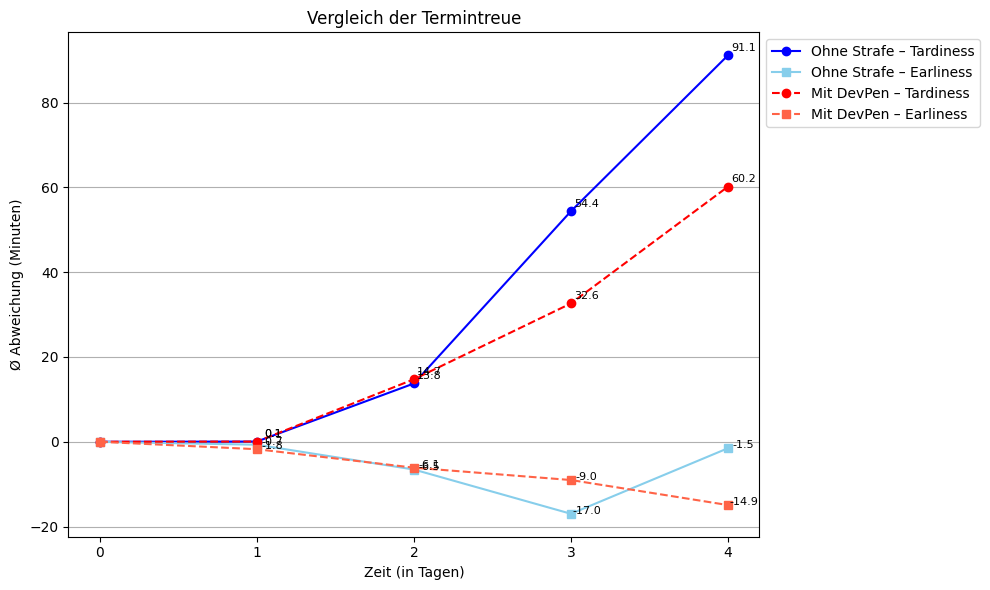

In [12]:
simple_mean_tardiness, simple_mean_earliness = calc.compute_mean_tardiness_earliness(df_plan_simple_last_ops_list)
devpen_mean_tardiness, devpen_mean_earliness = calc.compute_mean_tardiness_earliness(df_plan_devpen_last_ops_list)

proof.plot_tardiness_earliness_two_methods(
    tardiness_A=simple_mean_tardiness,
    earliness_A=simple_mean_earliness,
    tardiness_B=devpen_mean_tardiness,
    earliness_B=devpen_mean_earliness,
    labels=("Ohne Strafe", "Mit DevPen"),
    ylabel="Ø Abweichung (Minuten)",
    subtitle = "",
    as_percentage=False
)

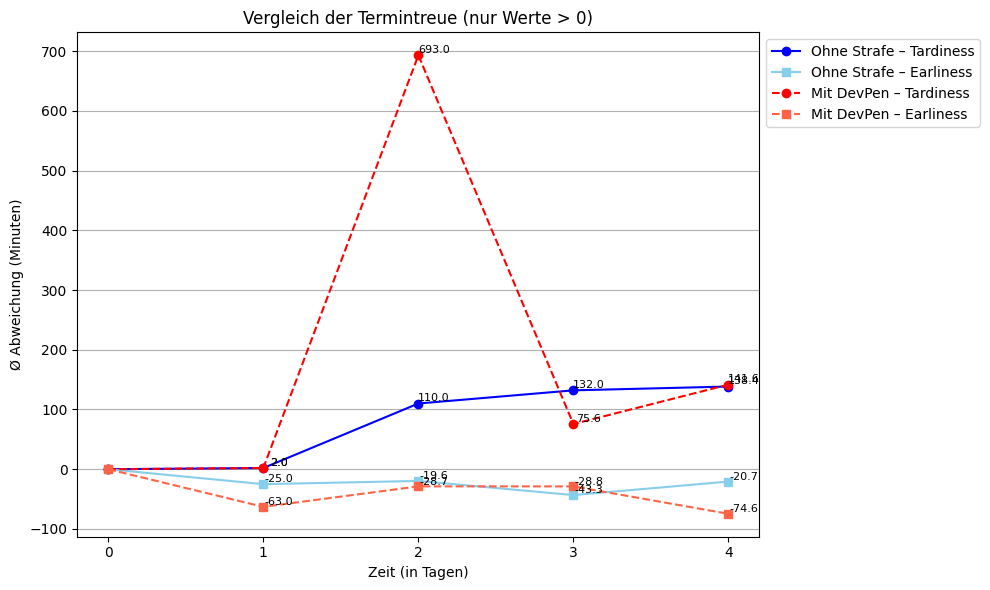

In [13]:
simple_mean_tardiness, simple_mean_earliness = calc.compute_nonzero_mean_tardiness_earliness(df_plan_simple_last_ops_list)
devpen_mean_tardiness, devpen_mean_earliness = calc.compute_nonzero_mean_tardiness_earliness(df_plan_devpen_last_ops_list)

proof.plot_tardiness_earliness_two_methods(
    tardiness_A=simple_mean_tardiness,
    earliness_A=simple_mean_earliness,
    tardiness_B=devpen_mean_tardiness,
    earliness_B=devpen_mean_earliness,
    labels=("Ohne Strafe", "Mit DevPen"),
    ylabel="Ø Abweichung (Minuten)",
    subtitle = "(nur Werte > 0)",
    as_percentage=False
)

### Plan-Nervosität (angelehnt an Wu)

In [14]:
# Totale Abweichung (Summe)
deviations_simple = calc.compute_daily_starttime_deviations(df_plan_simple_list)
deviations_simple

[0.0, np.int64(27), np.int64(3046), np.int64(25254), np.int64(31304)]

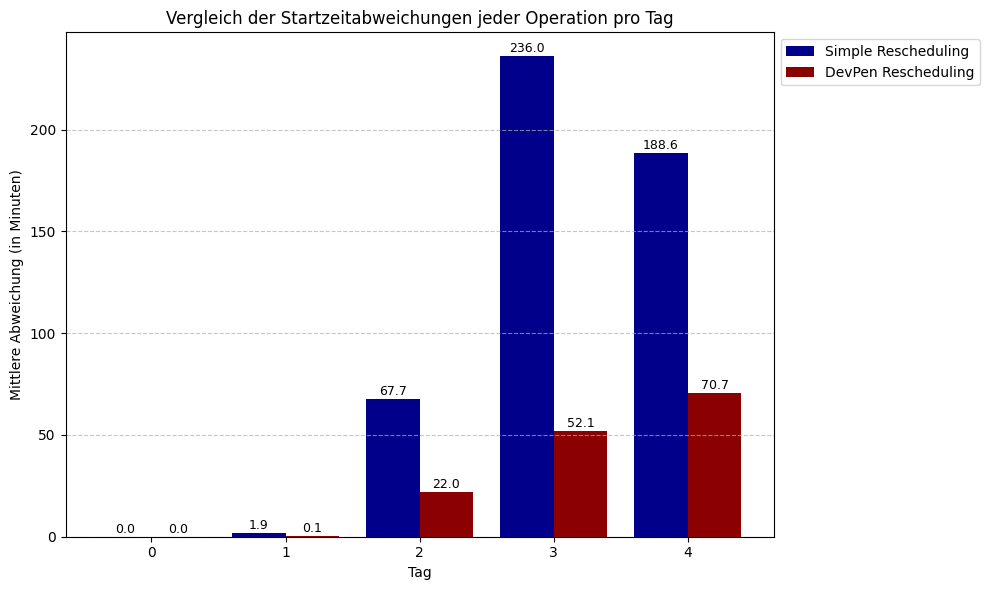

In [15]:
# Mittlere Abweichung
deviations_simple = calc.compute_daily_starttime_deviations(df_plan_simple_list, method="mean")
deviations_devpen = calc.compute_daily_starttime_deviations(df_plan_devpen_list, method="mean")

# Plot
proof.plot_two_starttime_deviation_bars(deviations_simple, deviations_devpen,
                                  label_A="Simple Rescheduling",
                                  label_B="DevPen Rescheduling",
                                  ylabel="Mittlere Abweichung")


# Proof of Concept

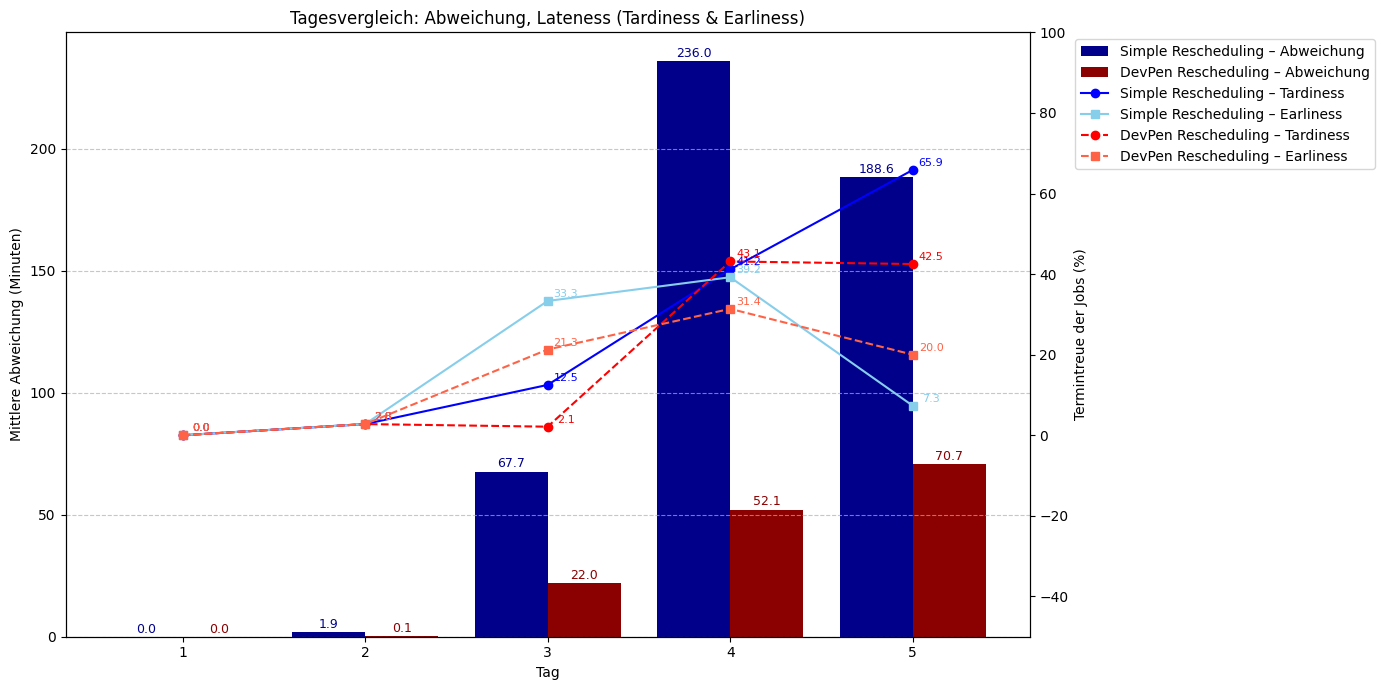

In [16]:
simple_tardi_ratio, simple_earli_ratio, simple_ideal_ratio = calc.compute_tardiness_earliness_ideal_ratios(df_plan_simple_last_ops_list)
devpen_tardi_ratio, devpen_earli_ratio, devpen_ideal_ratio = calc.compute_tardiness_earliness_ideal_ratios(df_plan_devpen_last_ops_list)

proof.proof_of_concept_v2(
    dev_A=deviations_simple,
    dev_B=deviations_devpen,
    tardiness_A=simple_tardi_ratio,
    earliness_A=simple_earli_ratio,
    tardiness_B=devpen_tardi_ratio,
    earliness_B=devpen_earli_ratio,
    label_A="Simple Rescheduling",
    label_B="DevPen Rescheduling",
    title="Tagesvergleich: Abweichung, Lateness (Tardiness & Earliness)",
    ylabel_left="Mittlere Abweichung (Minuten)",
    ylabel_right="Termintreue der Jobs",
    y_right_lim_min = -50,
    y_right_lim_max = 100,
    as_percentage=True  # zeigt Tardiness/Earliness in Prozent
)

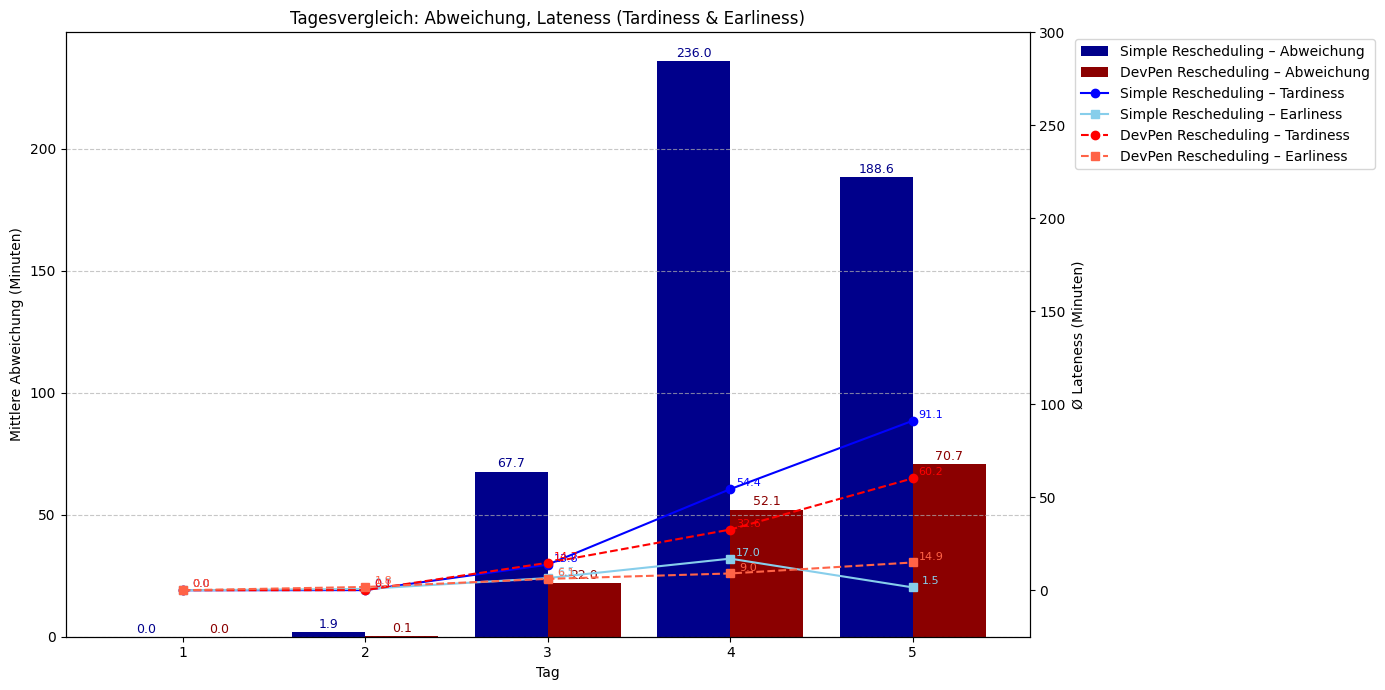

In [17]:
simple_mean_tardiness, simple_mean_earliness = calc.compute_mean_tardiness_earliness(df_plan_simple_last_ops_list)
devpen_mean_tardiness, devpen_mean_earliness = calc.compute_mean_tardiness_earliness(df_plan_devpen_last_ops_list)

proof.proof_of_concept_v2(
    dev_A=deviations_simple,
    dev_B=deviations_devpen,
    tardiness_A=simple_mean_tardiness,
    earliness_A=simple_mean_earliness,
    tardiness_B=devpen_mean_tardiness,
    earliness_B=devpen_mean_earliness,
    label_A="Simple Rescheduling",
    label_B="DevPen Rescheduling",
    title="Tagesvergleich: Abweichung, Lateness (Tardiness & Earliness)",
    ylabel_left="Mittlere Abweichung (Minuten)",
    ylabel_right="Ø Lateness",
    y_right_lim_min = -25,
    y_right_lim_max=300,
    as_percentage=False
)


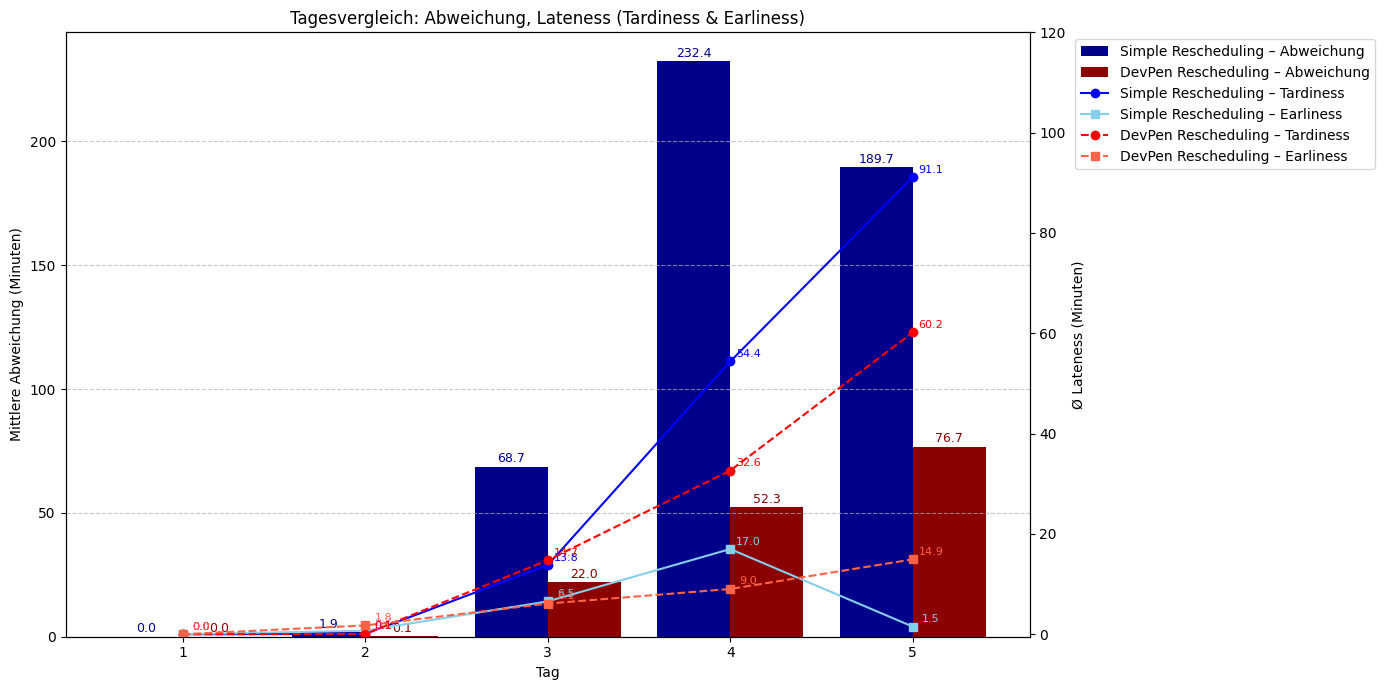

In [18]:
# Mittlere Abweichung
deviations_simple = calc.compute_daily_starttime_deviations(df_plan_simple_list, method="mean", with_T1= False)
deviations_devpen = calc.compute_daily_starttime_deviations(df_plan_devpen_list, method="mean", with_T1= False)

proof.proof_of_concept_v2(
    dev_A=deviations_simple,
    dev_B=deviations_devpen,
    tardiness_A=simple_mean_tardiness,
    earliness_A=simple_mean_earliness,
    tardiness_B=devpen_mean_tardiness,
    earliness_B=devpen_mean_earliness,
    label_A="Simple Rescheduling",
    label_B="DevPen Rescheduling",
    title="Tagesvergleich: Abweichung, Lateness (Tardiness & Earliness)",
    ylabel_left="Mittlere Abweichung (Minuten)",
    ylabel_right="Ø Lateness",
    y_right_lim_min = -0.5,
    y_right_lim_max=120,
    as_percentage=False
)
